<a href="https://colab.research.google.com/github/devbabbar7/Udacity-Introduction-to-Tensorflow-for-Deep-Learning/blob/main/l08c08_forecasting_with_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Forecasting with an LSTM

## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

In [2]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
def trend(time, slope=0):
    return slope * time
  
  
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

  
def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)
  
  
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level
  

def sequential_window_dataset(series, window_size):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=window_size, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size + 1))
    ds = ds.map(lambda window: (window[:-1], window[1:]))
    return ds.batch(1).prefetch(1)

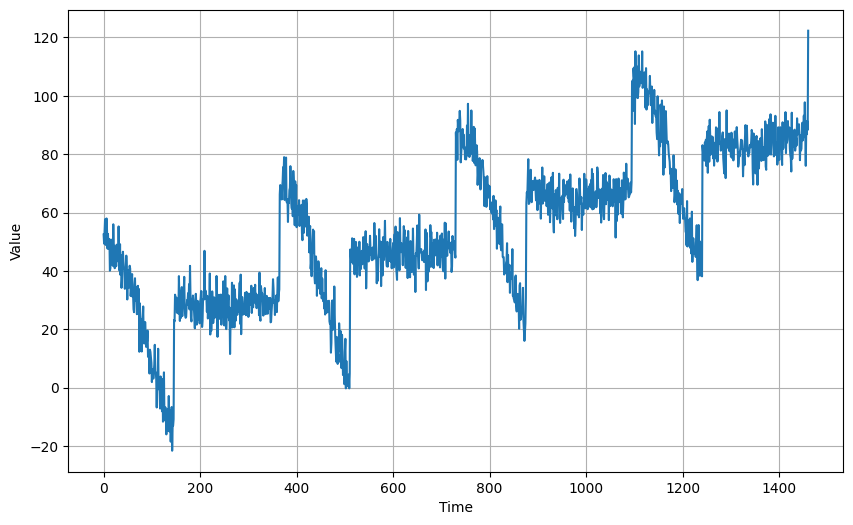

In [3]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [4]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [5]:
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

## LSTM RNN Forecasting

In [6]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = sequential_window_dataset(x_train, window_size)

model = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                    batch_input_shape=[1, None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
reset_states = ResetStatesCallback()
optimizer = keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100,
                    callbacks=[lr_schedule, reset_states])

Epoch 1/100
33/33 [==============================] - 11s 33ms/step - loss: 130.3622 - mae: 130.8622 - lr: 1.0000e-08
Epoch 2/100
33/33 [==============================] - 0s 11ms/step - loss: 123.2011 - mae: 123.7011 - lr: 1.1220e-08
Epoch 3/100
33/33 [==============================] - 0s 9ms/step - loss: 114.5654 - mae: 115.0654 - lr: 1.2589e-08
Epoch 4/100
33/33 [==============================] - 0s 10ms/step - loss: 104.7698 - mae: 105.2698 - lr: 1.4125e-08
Epoch 5/100
33/33 [==============================] - 0s 14ms/step - loss: 93.6480 - mae: 94.1480 - lr: 1.5849e-08
Epoch 6/100
33/33 [==============================] - 1s 15ms/step - loss: 80.9723 - mae: 81.4723 - lr: 1.7783e-08
Epoch 7/100
33/33 [==============================] - 0s 15ms/step - loss: 66.4529 - mae: 66.9528 - lr: 1.9953e-08
Epoch 8/100
33/33 [==============================] - 0s 12ms/step - loss: 49.6567 - mae: 50.1562 - lr: 2.2387e-08
Epoch 9/100
33/33 [==============================] - 0s 14ms/step - loss: 30.124

(1e-08, 0.0001, 0.0, 30.0)

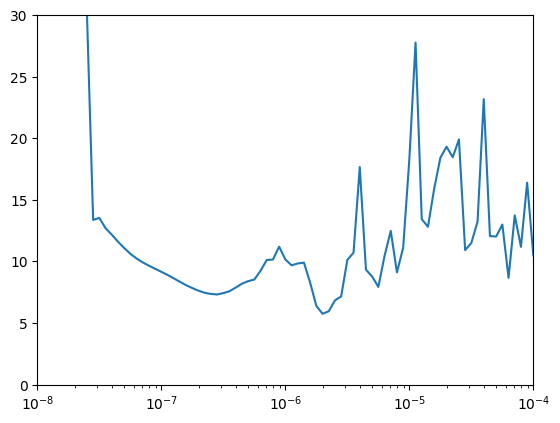

In [7]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [8]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = sequential_window_dataset(x_train, window_size)
valid_set = sequential_window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                         batch_input_shape=[1, None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
optimizer = keras.optimizers.SGD(lr=5e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
reset_states = ResetStatesCallback()
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint, reset_states])

Epoch 1/500
33/33 [==============================] - 4s 45ms/step - loss: 2595.8372 - mae: 2596.3367 - val_loss: 2580.2375 - val_mae: 2580.7378
Epoch 2/500
33/33 [==============================] - 0s 13ms/step - loss: 1419.3602 - mae: 1419.8601 - val_loss: 1866.6658 - val_mae: 1867.1659
Epoch 3/500
33/33 [==============================] - 0s 14ms/step - loss: 1966.1029 - mae: 1966.6027 - val_loss: 11.0582 - val_mae: 11.5488
Epoch 4/500
33/33 [==============================] - 0s 9ms/step - loss: 2377.0198 - mae: 2377.5200 - val_loss: 3098.8618 - val_mae: 3099.3621
Epoch 5/500
33/33 [==============================] - 0s 9ms/step - loss: 3249.4836 - mae: 3249.9834 - val_loss: 3908.5168 - val_mae: 3909.0168
Epoch 6/500
33/33 [==============================] - 0s 9ms/step - loss: 2071.0913 - mae: 2071.5913 - val_loss: 3338.8462 - val_mae: 3339.3464
Epoch 7/500
33/33 [==============================] - 0s 9ms/step - loss: 2756.5742 - mae: 2757.0740 - val_loss: 1568.9917 - val_mae: 1569.4917


In [9]:
model = keras.models.load_model("my_checkpoint.h5")

In [10]:
rnn_forecast = model.predict(series[np.newaxis, :, np.newaxis])
rnn_forecast = rnn_forecast[0, split_time - 1:-1, 0]

1/1 [==============================] - 1s 655ms/step


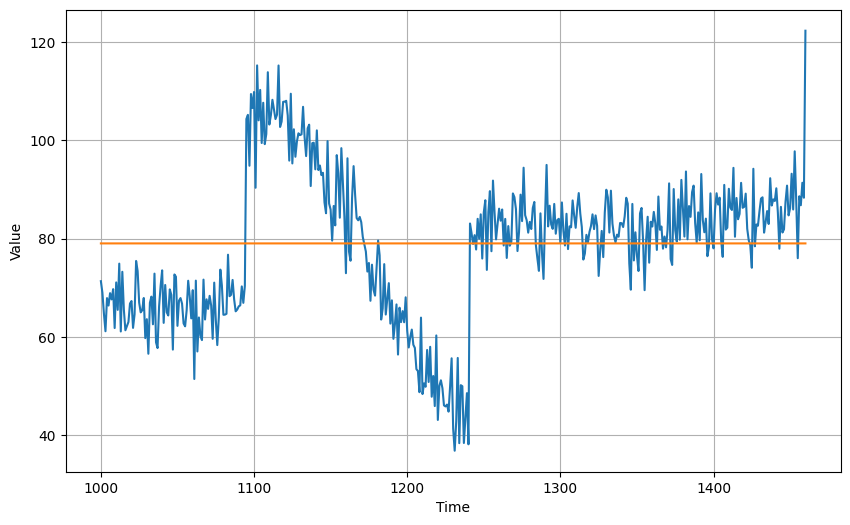

In [11]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [12]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

11.582483